<a href="https://colab.research.google.com/github/Zardian18/Waste-Classificaiton/blob/master/Bio_Degradable_Non_Bio_Degradable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bio-Degradable and Non-bio-Degradable waste classification

## Getting Data ready

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [3]:
!kaggle datasets download -d "rayhanzamzamy/non-and-biodegradable-waste-dataset"

non-and-biodegradable-waste-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2023-08-24 13:13:56--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11274 (11K) [text/plain]
Saving to: ‘helper.py.1’

helper.py.1         100%[===================>]  11.01K  --.-KB/s    in 0s      

2023-08-24 13:13:56 (104 MB/s) - ‘helper.py.1’ saved [11274/11274]



In [5]:
from helper import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [6]:
unzip_data("non-and-biodegradable-waste-dataset.zip")

In [7]:
walk_through_dir("TRAIN.1")

There are 2 directories and 0 images in 'TRAIN.1'.
There are 0 directories and 29961 images in 'TRAIN.1/B'.
There are 0 directories and 29961 images in 'TRAIN.1/N'.


In [8]:
walk_through_dir("TRAIN.2")

There are 2 directories and 0 images in 'TRAIN.2'.
There are 0 directories and 29961 images in 'TRAIN.2/B'.
There are 0 directories and 29961 images in 'TRAIN.2/N'.


In [9]:
walk_through_dir("TRAIN.3")

There are 2 directories and 0 images in 'TRAIN.3'.
There are 0 directories and 29961 images in 'TRAIN.3/B'.
There are 0 directories and 29961 images in 'TRAIN.3/N'.


In [10]:
walk_through_dir("TRAIN.4")

There are 2 directories and 0 images in 'TRAIN.4'.
There are 0 directories and 29962 images in 'TRAIN.4/B'.
There are 0 directories and 29962 images in 'TRAIN.4/N'.


In [11]:
walk_through_dir("TEST")

There are 2 directories and 0 images in 'TEST'.
There are 0 directories and 8363 images in 'TEST/B'.
There are 0 directories and 8363 images in 'TEST/N'.


In [12]:
train1_dir="TRAIN.1/"
train2_dir="TRAIN.2/"
train3_dir="TRAIN.3/"
train4_dir="TRAIN.4/"
test_dir="TEST/"

## Preprocessing data

In [13]:
import tensorflow as tf

IMG_SIZE=(224,224)
BATCH_SIZE=32

train_dirs=[train1_dir, train2_dir, train3_dir, train4_dir]
train_dataset=[]

for train_dir in train_dirs:
  train_data=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=BATCH_SIZE)
  train_dataset.append(train_data)


test_dataset= tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                  image_size=IMG_SIZE,
                                                                  label_mode="binary",
                                                                  batch_size=BATCH_SIZE)

Found 59922 files belonging to 2 classes.
Found 59922 files belonging to 2 classes.
Found 59922 files belonging to 2 classes.
Found 59924 files belonging to 2 classes.
Found 16726 files belonging to 2 classes.


In [14]:
train_dataset

[<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>]

In [15]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

## Viewing the data

In [16]:
train_dataset[0].class_names

['B', 'N']

In [17]:
test_dataset.class_names

['B', 'N']

In [18]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import os

def plot_img_from_dir(directory=train1_dir, target_class="B"):
  target_dir= directory+target_class
  random_img= random.sample(os.listdir(target_dir),1)

  img_path= target_dir+ "/"+ random_img[0]

  img=mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis(False)
  plt.title(f"Label: {target_class}")
  print(img.shape)

(200, 200, 3)


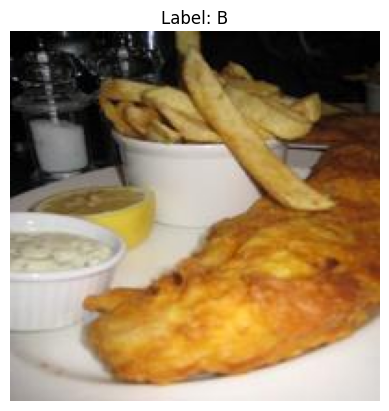

In [19]:
plot_img_from_dir()

(200, 200, 3)


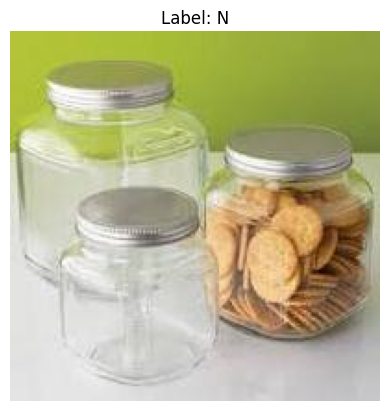

In [44]:
plot_img_from_dir(target_class="N")

## Selecting Model

### Building the model

In [20]:
base_model= tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False)
base_model.trainable=False # freezing all the layers

inputs= tf.keras.layers.Input(shape=IMG_SIZE+(3,), name="input_layer")
x= base_model(inputs)
x= tf.keras.layers.GlobalAveragePooling2D(name="global_layer")(x)
outputs=tf.keras.layers.Dense(1, activation="sigmoid")(x)

model0= tf.keras.Model(inputs, outputs)

In [21]:
model0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, None, None, 1536)  12930622 
 al)                                                             
                                                                 
 global_layer (GlobalAverage  (None, 1536)             0         
 Pooling2D)                                                      
                                                                 
 dense (Dense)               (None, 1)                 1537      
                                                                 
Total params: 12,932,159
Trainable params: 1,537
Non-trainable params: 12,930,622
_________________________________________________________________


### Compiling the model

In [22]:
model0.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])


### Fitting the model

In [23]:
validation_dataset= [test_dataset]* len(train_dataset)
steps_per_epoch= [len(train_data) for train_data in train_dataset]
validation_steps=[int(0.25* len(validation_data)) for validation_data in validation_dataset]


In [24]:
histories0= []
current_epoch=0
for train_data, steps, val_data, val_steps in zip(train_dataset, steps_per_epoch, validation_dataset, validation_steps):
  history= model0.fit(train_data,
                      epochs=current_epoch+1,
                      steps_per_epoch=steps,
                      validation_data=val_data,
                      validation_steps=val_steps,
                      initial_epoch=current_epoch,
                      callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="base_model")])
  current_epoch+1
  histories0.append(history)

Saving TensorBoard log files to: transfer_learning/base_model/20230824-131559
1873/1873 [==============================] - 215s 103ms/step - loss: 0.0909 - accuracy: 0.9713 - val_loss: 0.1726 - val_accuracy: 0.9373
Saving TensorBoard log files to: transfer_learning/base_model/20230824-131933
1873/1873 [==============================] - 194s 103ms/step - loss: 0.0737 - accuracy: 0.9757 - val_loss: 0.1606 - val_accuracy: 0.9353
Saving TensorBoard log files to: transfer_learning/base_model/20230824-132256
1873/1873 [==============================] - 203s 108ms/step - loss: 0.0656 - accuracy: 0.9783 - val_loss: 0.1617 - val_accuracy: 0.9370
Saving TensorBoard log files to: transfer_learning/base_model/20230824-132718
1873/1873 [==============================] - 202s 107ms/step - loss: 0.0653 - accuracy: 0.9781 - val_loss: 0.1500 - val_accuracy: 0.9425


In [38]:
results0=model0.evaluate(test_dataset)
results0

523/523 [==============================] - 48s 91ms/step - loss: 0.1534 - accuracy: 0.9416


[0.15336941182613373, 0.9415879249572754]

In [29]:
model0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Function  (None, None, None, 1536)  12930622 
 al)                                                             
                                                                 
 global_layer (GlobalAverage  (None, 1536)             0         
 Pooling2D)                                                      
                                                                 
 dense (Dense)               (None, 1)                 1537      
                                                                 
Total params: 12,932,159
Trainable params: 1,537
Non-trainable params: 12,930,622
_________________________________________________________________


## Fine tuning

In [31]:
for i, layer in enumerate(model0.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block3a_expand_conv False
34 block3a_expand_bn False
35 block3a_expand_activation False
36 block3a_project_conv False
37 bl

Now let's unfreeze the last 10 layers

In [36]:
model0.trainable=True

for layer in model0.layers[1].layers[:-10]:
  layer.trainable=False

In [37]:
for i, layer in enumerate(model0.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block3a_expand_conv False
34 block3a_expand_bn False
35 block3a_expand_activation False
36 block3a_project_conv False
37 bl

Now the last 10 layers are trainable

Fitting the model for 4 more epochs

## Re-fitting

In [40]:
histories1= []
for train_data, steps, val_data, val_steps in zip(train_dataset, steps_per_epoch, validation_dataset, validation_steps):
  history= model0.fit(train_data,
                      epochs=5,
                      steps_per_epoch=steps,
                      validation_data=val_data,
                      validation_steps=val_steps,
                      initial_epoch=4,
                      callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="fine_tune_model")])

  histories1.append(history)

Saving TensorBoard log files to: transfer_learning/fine_tune_model/20230824-135143
Epoch 5/5
1873/1873 [==============================] - 203s 108ms/step - loss: 0.0601 - accuracy: 0.9798 - val_loss: 0.1570 - val_accuracy: 0.9413
Saving TensorBoard log files to: transfer_learning/fine_tune_model/20230824-135506
Epoch 5/5
1873/1873 [==============================] - 192s 102ms/step - loss: 0.0649 - accuracy: 0.9775 - val_loss: 0.1524 - val_accuracy: 0.9418
Saving TensorBoard log files to: transfer_learning/fine_tune_model/20230824-135818
Epoch 5/5
1873/1873 [==============================] - 192s 102ms/step - loss: 0.0598 - accuracy: 0.9798 - val_loss: 0.1466 - val_accuracy: 0.9433
Saving TensorBoard log files to: transfer_learning/fine_tune_model/20230824-140130
Epoch 5/5
1873/1873 [==============================] - 195s 103ms/step - loss: 0.0637 - accuracy: 0.9790 - val_loss: 0.1597 - val_accuracy: 0.9401


In [41]:
results1=model0.evaluate(test_dataset)

523/523 [==============================] - 50s 96ms/step - loss: 0.1599 - accuracy: 0.9393


In [42]:
results1

[0.15991827845573425, 0.9392562508583069]

In [43]:
results0

[0.15336941182613373, 0.9415879249572754]

Here, the accuracy after fine tuning is lower than the accuracy before it